In [1]:
!pip install MiniSom torch

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader

In [3]:
dataset = pd.read_csv('../data/Credit_Card_Applications.csv')
X = dataset.iloc[:, :-1].values 
y = dataset.iloc[:, -1].values

In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
X = sc.fit_transform(X)

In [5]:
from minisom import MiniSom
som = MiniSom(x=10, y=10, input_len= 15, sigma= 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

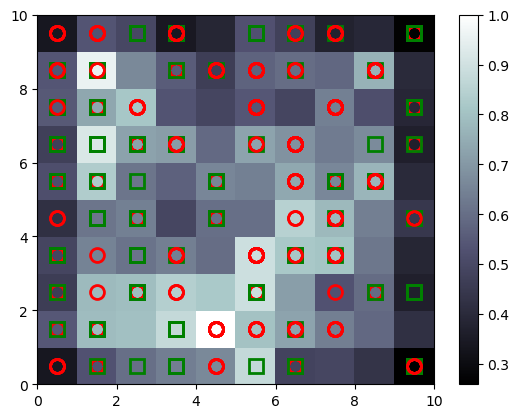

In [6]:
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

In [11]:
mappings = som.win_map(X)
frauds = np.concatenate((mappings[(4, 1)], mappings[(1,8)]), axis = 0)
frauds = sc.inverse_transform(frauds)

In [12]:
customers = dataset.iloc[:, 1:].values 

In [13]:
print(np.size(customers, 0), np.size(customers, 1))

690 15


In [14]:
is_fraud = np.zeros(len(dataset)).reshape(-1, 1)

In [15]:
print(np.size(is_fraud, 0), np.size(is_fraud, 1))

690 1


In [16]:
for i in range(len(dataset)):
    if dataset.iloc[i, 0] in frauds:
        is_fraud[i] = 1

In [17]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)

In [18]:
model = nn.Sequential()
model.append(nn.Linear(in_features = 15, out_features = 6))
model.append(nn.ReLU())
model.append(nn.Linear(in_features = 6, out_features = 6))
model.append(nn.ReLU())
model.append(nn.Linear(in_features = 6, out_features = 1))
model.append(nn.Sigmoid())

Sequential(
  (0): Linear(in_features=15, out_features=6, bias=True)
  (1): ReLU()
  (2): Linear(in_features=6, out_features=6, bias=True)
  (3): ReLU()
  (4): Linear(in_features=6, out_features=1, bias=True)
  (5): Sigmoid()
)

In [19]:
model = torch.compile(model)

In [20]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            corrrect += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100 + correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [21]:
train_dataloader = DataLoader(list(zip(customers, is_fraud)), batch_size = 32, shuffle=True)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [22]:
epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
---------------------
loss: 0.673275 [   32/  690]
Epoch 2
---------------------
loss: 0.276828 [   32/  690]
Epoch 3
---------------------
loss: 0.152850 [   32/  690]
Epoch 4
---------------------
loss: 0.116652 [   32/  690]
Epoch 5
---------------------
loss: 0.088408 [   32/  690]
Done!


In [34]:
y_pred = model(torch.tensor(customers, dtype = torch.float32)).detach()

In [35]:
y_pred = np.concatenate((dataset.iloc[:, 0:1].values, y_pred), axis = 1)

In [38]:
y_pred = y_pred[y_pred[:, 1].argsort()]

In [39]:
y_pred

array([[1.57901130e+07, 1.67788485e-08],
       [1.56514600e+07, 6.93590709e-06],
       [1.56546250e+07, 1.80158604e-05],
       ...,
       [1.57384870e+07, 2.03722402e-01],
       [1.57734210e+07, 2.04542339e-01],
       [1.57278110e+07, 2.18007877e-01]])